Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental import preprocessing

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Evaluating the first round of training of the ResNet 50 Model 
- The model intially struggles with class imbalance since there are low accuracy rates with a bias towards classes with more data such as Normal, Other and Diabetes. 
- Training accuracy improved over time but validation accuracy lagged suggesting overfitting. Loss decreased steadily, yet training and validation loss diverged.
- Model frequently misclassified minority classes (e.g., Diabetes as Normal). Therefore there is a need to implement class balance correction techniques for better model generalisation and performance. 

Below images related to these mentioned issues are displayed:


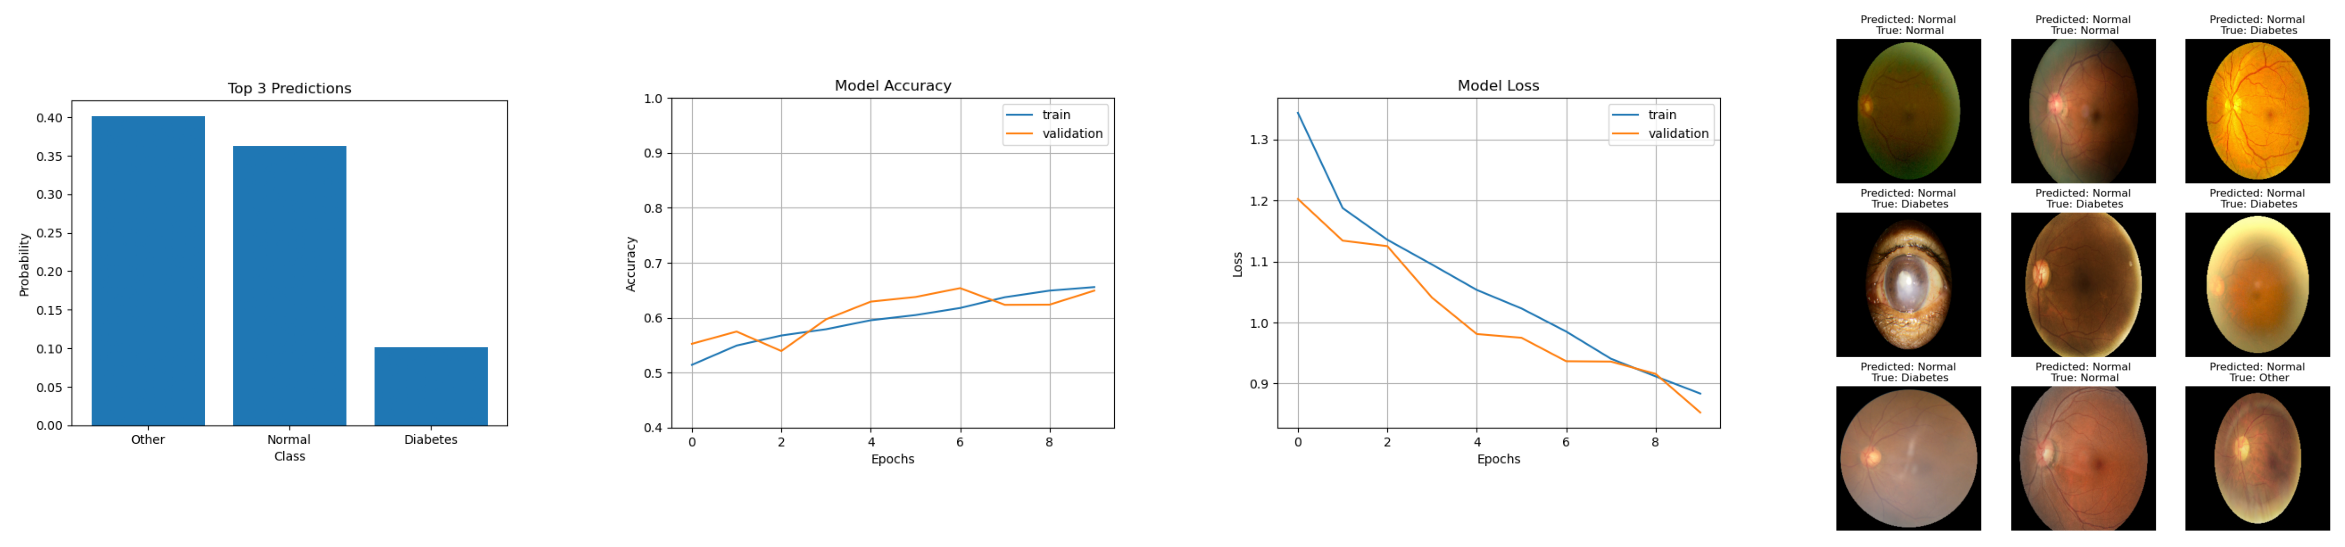

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(30,10))

pred_graph = plt.imread('resnet_50_model/intial-eval/baseTop3predictions.png')
axs[0].imshow(pred_graph)
axs[0].axis('off')

model_acc = plt.imread('resnet_50_model/intial-eval/baseAccuracy.png')
axs[1].imshow(model_acc)
axs[1].axis('off')

model_loss = plt.imread('resnet_50_model/intial-eval/baseLoss.png')
axs[2].imshow(model_loss)
axs[2].axis('off')

test_pred = plt.imread('resnet_50_model/intial-eval/baseTestPred.png')
axs[3].imshow(test_pred)
axs[3].axis('off')

plt.show()



Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, and O are minority classes since they have low image samples, causing class imbalance. 

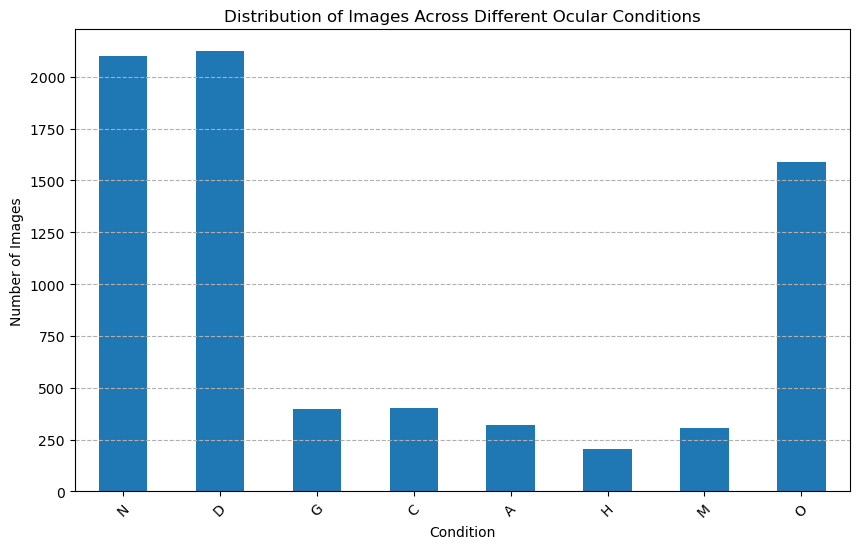

In [5]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [6]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Dealing with class imbalance - Calculating class weights 
- This approach to addressing class imbalance involves calculating class weights to make the CNN model more sensitive to underrepresented classes, thereby enhancing its performance on imbalanced datasets. A higher class weight signifies that a single sample from a class with a higher weight will carry the same importance as seven samples from a class with lower class weights.

In [7]:
# The dataset is imbalanced, so we will use class weights to balance it out during training                     
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / class_counts[0],
    1: total_samples / class_counts[1],
    2: total_samples / class_counts[2],
    3: total_samples / class_counts[3],
    4: total_samples / class_counts[4],
    5: total_samples / class_counts[5],
    6: total_samples / class_counts[6],
    7: total_samples / class_counts[7]
} 

print(class_weights)

{0: 3.5406949071870537, 1: 3.5040037682524727, 2: 18.738035264483628, 3: 18.50497512437811, 4: 23.31974921630094, 5: 36.645320197044335, 6: 24.31045751633987, 7: 4.684508816120907}


Loading and Visualising the Minority Class Dataset 
- This dataset will include images from the training data that are classified as any of the minority classes -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities)

In [8]:
from concurrent.futures import ThreadPoolExecutor
images_path = 'dataset/ODIR-5K/Training Images/'  
minority_classes = ['G', 'C', 'A', 'H', 'M', 'O']

minority_images = []
minority_labels = []

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_minority_image_result(result):
    img, label = result
    if img is not None:
        minority_images.append(img)
        minority_labels.append(label)

# Use ThreadPoolExecutor to load and process images that match minority_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in df_data.iterrows():
        # For each minority class, check if the condition is present for either eye
        for minority_class in minority_classes:
            if minority_class in row and row[minority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[minority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    futures.append(executor.submit(load_process_minority_image, left_image_path, (row['target'])))
                if 'Right-Fundus' + minority_class in row and row[minority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    futures.append(executor.submit(load_process_minority_image, right_image_path, (row['target'])))
    
    
    for future in futures:
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

length_of_minority_images = len(minority_images)
print(length_of_minority_images)

print(f"Shape of training images: {minority_images.shape}")
print(f"Shape of training labels: {minority_labels.shape}")

3215
Shape of training images: (3215, 224, 224, 3)
Shape of training labels: (3215,)


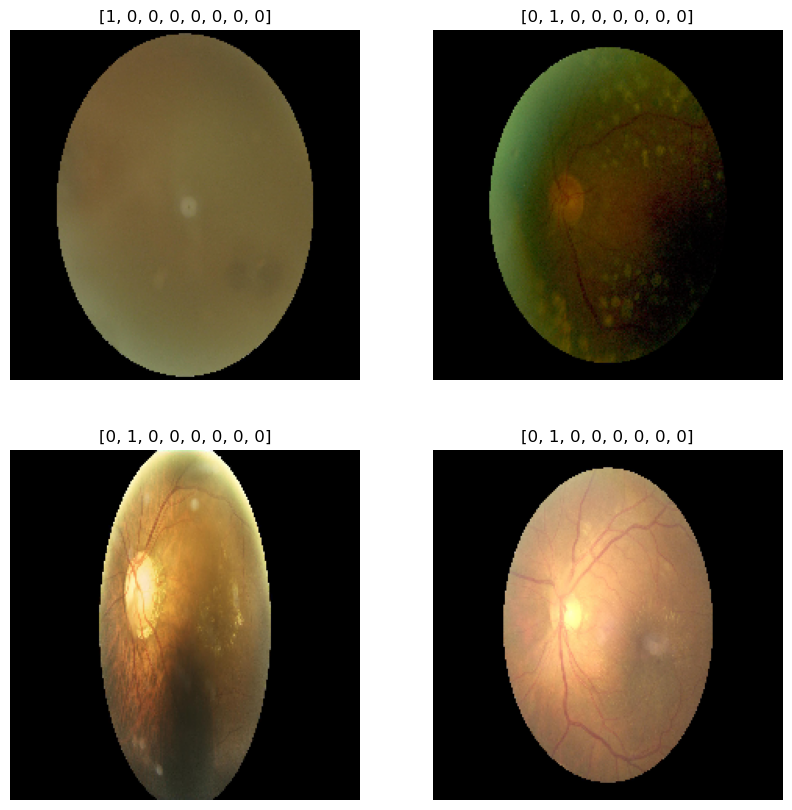

In [9]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(minority_images[i].astype('uint8'))
    plt.title(minority_labels[i])
    plt.axis('off')

plt.show()


Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images.

In [10]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm for the progress bar

images_path = 'dataset/ODIR-5K/Training Images/'  
minority_classes = ['G', 'C', 'A', 'H', 'M', 'O']

minority_images = []
minority_labels = []

augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50,  
    fill_mode='nearest' 
)

minority_class_counts= df_data[['G', 'C', 'A', 'H', 'M', 'O']].sum()
# Count images per class and initialize the dictionary
class_image_counts = minority_class_counts.to_dict()


def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_minority_image_result(result):
    img, label = result
    if img is not None:
        # Check if we need more images for this class
        if class_image_counts[label] < 2000:
            # Append the original image
            minority_images.append(img)
            minority_labels.append(label)
            class_image_counts[label] += 1
            
            # Augment images until we reach 2000 for this class
            while class_image_counts[label] < 2000:
                augmented_img = augmentation.random_transform(img)
                minority_images.append(augmented_img)
                minority_labels.append(label)
                class_image_counts[label] += 1
        else:
            # If we already have enough images, we can choose to do nothing
            # or we could replace some of the original images with augmented ones
            pass

# Use ThreadPoolExecutor to load and process images that match minority_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        # For each minority class, check if the condition is present for either eye
        for minority_class in minority_classes:
            if minority_class in row and row[minority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[minority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, left_image_path, minority_class))
                if 'Right-Fundus' in row and row[minority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, right_image_path, minority_class))
    
    
    for future in tqdm(futures, desc='Collecting results'):
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

# Print out the class counts to verify
print("Image counts per class after augmentation:")
for cls in minority_classes:
    print(f"Class {cls}: {class_image_counts[cls]}")

Processing images: 100%|██████████| 6392/6392 [00:00<00:00, 8768.68it/s]


Image counts per class after augmentation:
Class G: 2000
Class C: 2000
Class A: 2000
Class H: 2000
Class M: 2000
Class O: 2000


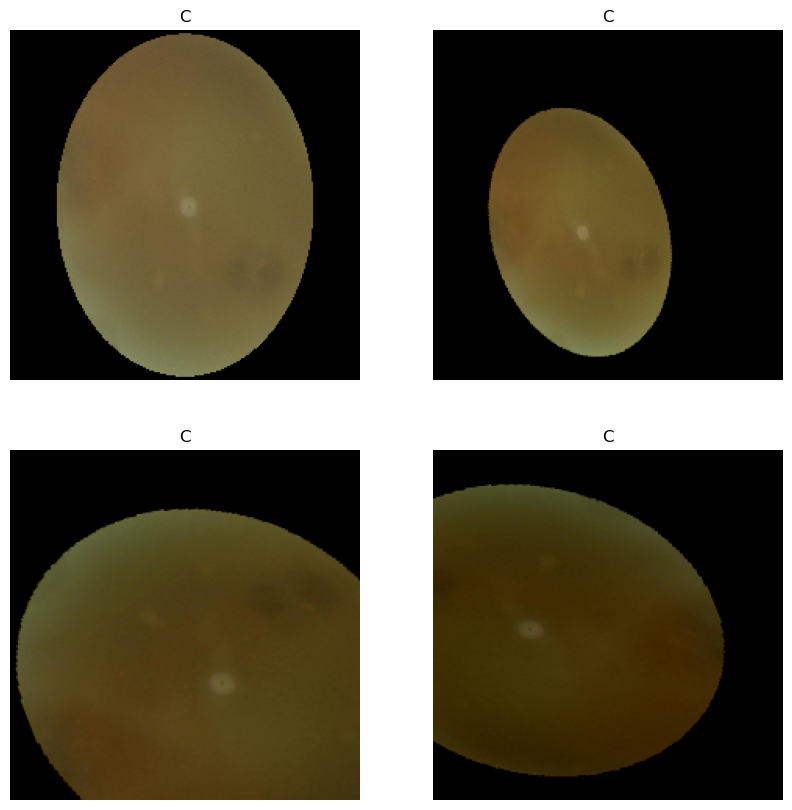

In [11]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(minority_images[i].astype('uint8'))
    plt.title(minority_labels[i])
    plt.axis('off')

plt.show()

Preparing augmentated data for training
- Splitting the augmented minority data into training and validation sets. 

In [12]:
minority_ds = tf.data.Dataset.from_tensor_slices((minority_images, minority_labels))

# Shuffle and batch the dataset
minority_ds = minority_ds.shuffle(buffer_size=len(minority_images))

# Normalize the images
minority_ds = minority_ds.map(lambda x, y: (x / 255.0, y))

# Calculate the number of samples for training
train_size = int(0.8 * len(minority_images))

# Split the dataset
train_dataset = minority_ds.take(train_size)
val_dataset = minority_ds.skip(train_size)

# Batch the datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

# Prefetch the datasets
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)